<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/3D_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q "monai-weekly[itk, pillow]"

     |████████████████████████████████| 522kB 2.3MB/s 
     |████████████████████████████████| 14.4MB 468kB/s 
     |████████████████████████████████| 10.3MB 24.2MB/s 
     |████████████████████████████████| 50.1MB 63kB/s 
     |████████████████████████████████| 14.0MB 21.4MB/s 
     |████████████████████████████████| 36.3MB 145kB/s 
     |████████████████████████████████| 68.0MB 77kB/s 


In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import logging
import os
import sys
import tempfile
import shutil

import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np

import monai
from monai.networks.nets import DenseNet121, Classifier
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, 
)
from torch.utils.data import DataLoader 
from monai.transforms import Transform
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandRotate90,
    Resize,
    Orientation,
    Orientationd,
    ScaleIntensity,
    AsChannelFirst,
    AsChannelLast,
    Activations,
    AddChannel,
    AsDiscrete,
    EnsureChannelFirst,
    RepeatChannel,
    RemoveRepeatedChannel,
    SplitChannel,
    SqueezeDim,
    ToTensor,
    Randomizable,
    LoadImaged,
    ToTensord,
)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 
from glob import glob
import logging
from abc import ABC, abstractmethod
from typing import Any, Callable, Dict, Generator, Hashable, Iterable, List, Optional, Tuple

import numpy as np
import torch

import numpy as np
from monai.transforms import Transform, AddChannel, AsChannelFirst


logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


MONAI version: 0.6.dev2123
Numpy version: 1.19.5
Pytorch version: 1.8.1+cu101
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 448c2527ad0c39aa7eb8a345ebd71e7f7985d374

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.5.0
gdown version: 3.6.4
TorchVision version: 0.9.1+cu101
ITK version: 5.1.2
tqdm version: 4.41.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



**Data Direction**

In [38]:
data_dir= "/content/drive/My Drive/Spleen_AI"

In [39]:
labels_all = pd.read_excel (r'/content/drive/MyDrive/Spleen_AI/labels.xlsx')
l=labels_all["label"].to_numpy()
print(l)
#print(labels_all["label"])

[1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1]


In [40]:
images = sorted(glob(os.path.join(data_dir, "Projekt2f", "*.nii.gz")))
print(len(images))
labels= l
#labels= np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1], dtype=np.int64)
print(len(labels))


124
124


**Check Data Shape**

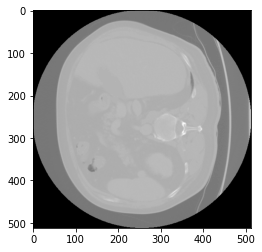

In [34]:
class ChannelFirstOrAdd(Transform):
    def __init__(self):
        self.channel_first = AsChannelFirst()
        self.add_channel = AddChannel()
        self.squeezedim = SqueezeDim()
    def __call__(self, im):
        ndims = im.ndim
        if ndims > 4:
            return self.squeezedim(im, dim=[2])   
                 
        #elif ndims == 5:
        #    return self.squeezedim(dim=5)
        #elif ndims <= 4:
           # return self.channel_first(im)
       
        else:
            return self.AsChannelFirst(im)
device = torch.device("cuda")
#Orientation(axcodes="LPI"), 
#SqueezeDim(dim=0), 
#train_transforms = Compose([ScaleIntensity(), ChannelFirstOrAdd(), Resize((96, 96, 96,0 , 0),mode="nearest"), ToTensor()])
transforms=Compose([ AddChannel(), ToTensor()])
check = ImageDataset(image_files=images[:2], labels=labels[:2],
                        transform=transforms)
check_loader = DataLoader(check, batch_size=1,
                          num_workers=1, pin_memory=torch.cuda.is_available())
for data,i in check_loader:
  inputs = data[0].to(device)
  plt.imshow(data[0][0, 0, :, :, 70], cmap="gray")
  #print(inputs.shape)

**Loading Data**

In [41]:
# Define transforms
train_transforms = Compose([ScaleIntensity(), AddChannel(), Resize(
    (96, 96, 96)), ToTensor()])
val_transforms = Compose(
    [ScaleIntensity(), AddChannel(), Resize((96, 96, 96)), ToTensor()])



# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels,
                        transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2,
                          num_workers=4, pin_memory=torch.cuda.is_available())
im, label = monai.utils.misc.first(check_loader)
#print(type(im), im.shape, label)

# create a training data loader
train_ds = ImageDataset(
    image_files=images[:110], labels=labels[:110], transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True,
                          num_workers=4, pin_memory=torch.cuda.is_available())

# create a validation data loader
val_ds = ImageDataset(
    image_files=images[110:], labels=labels[110:], transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2, num_workers=4,
                        pin_memory=torch.cuda.is_available())


to_onehot = AsDiscrete(to_onehot=True, n_classes=2)
act = Activations(softmax=True)



In [ ]:
for idx, (images, labels) in enumerate(train_loader):
      print(idx, im.shape, labels)

**Training**

In [42]:
# Create DenseNet121, CrossEntropyLoss and Adam optimizer
device = torch.device("cuda")
model = monai.networks.nets.DenseNet121(spatial_dims=3, in_channels=1, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

In [ ]:
# start a typical PyTorch training
val_interval = 3
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()
max_epochs = 30
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            num_correct = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(
                    device), val_data[1].to(device)
                val_outputs = model(val_images)
                value = torch.eq(val_outputs.argmax(dim=1), val_labels)
                metric_count += len(value)
                num_correct += value.sum().item()
            metric = num_correct / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           "/content/drive/My Drive/Spleen_AI/best_metric_model_classification3d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current accuracy: {:.4f} "
                "best accuracy: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_accuracy", metric, epoch + 1)
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")
writer.close()

**Evaluation Metrics**

                 precision    recall  f1-score   support

Liver_Cirrhosis       0.33      0.50      0.40         2
       Lymphoma       0.91      0.83      0.87        12

       accuracy                           0.79        14
      macro avg       0.62      0.67      0.63        14
   weighted avg       0.83      0.79      0.80        14



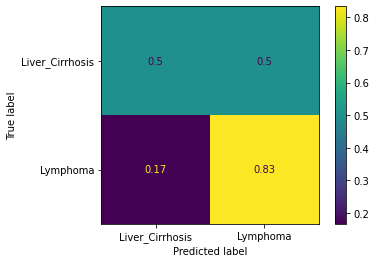

In [43]:
from enum import Enum
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
class Diagnosis(Enum):
    Liver_Cirrhosis = 0
    Lymphoma = 1
    

%matplotlib inline
# Load best model
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_classification3d_array.pth"))
model.to(device)
model.eval()

with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)

    for val_data in val_loader:
        val_images, val_labels = val_data[0].to(
            device), val_data[1].to(device),

        outputs = model(val_images)
        y_pred = torch.cat([y_pred, outputs.argmax(dim=1)], dim=0)
        y = torch.cat([y, val_labels], dim=0)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix (
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true',
)
cmm = ConfusionMatrixMetric (include_background=True, metric_name=["sensitivity","specificity","negative predictive value"])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis],
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

In [52]:
test_ds = ImageDataset(
    image_files=images, labels=labels, transform=train_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)
itera = iter(test_loader)


def get_next_im():
    test_data = next(itera)
    return test_data[0].to(device), test_data[1].unsqueeze(0).to(device)


def plot_occlusion_heatmap(im, heatmap):
    plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(im.cpu()))
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.colorbar()
    plt.show()

Computing occlusion sensitivity: 100%|██████████| 64/64 [00:00<00:00, 77.44it/s]


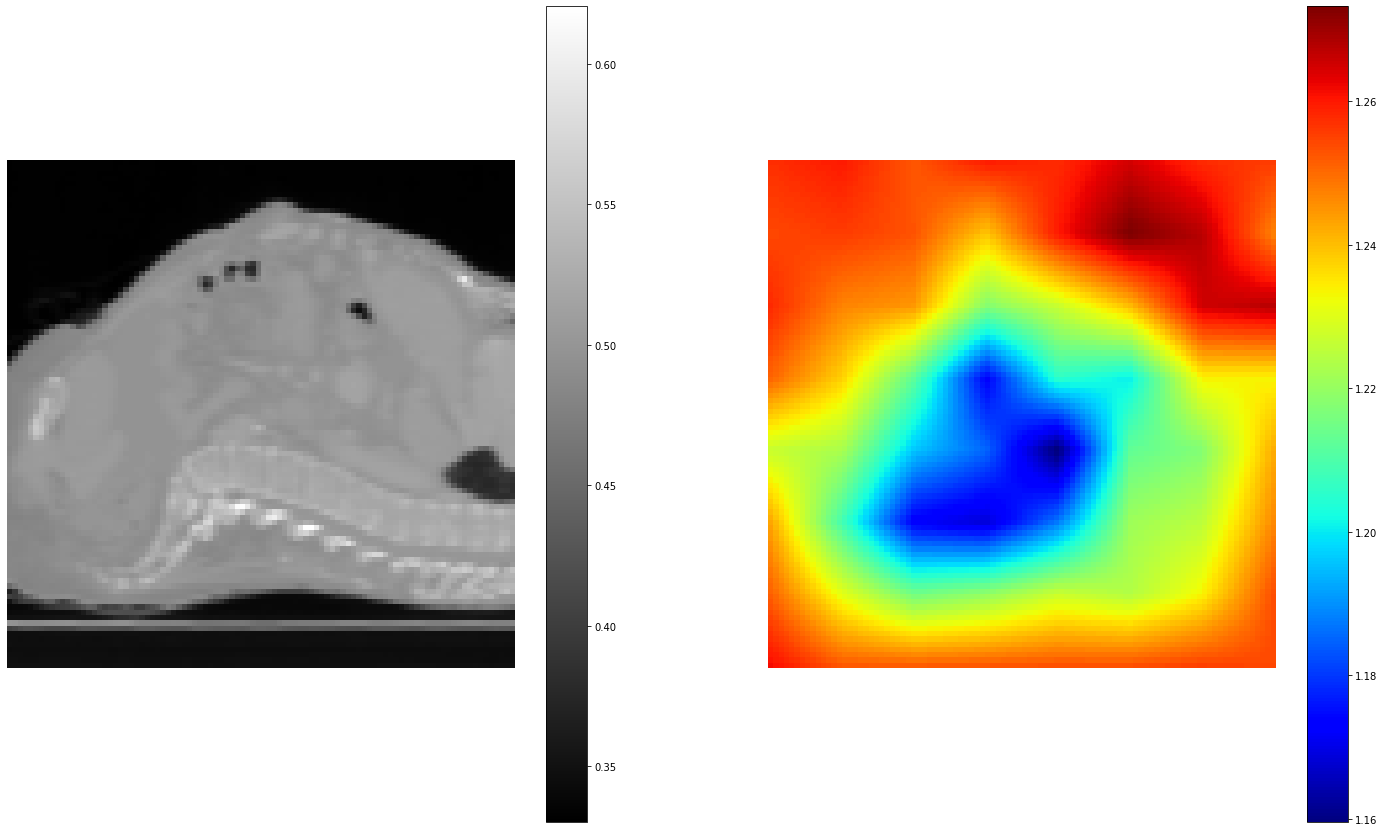

In [57]:
# Get a random image and its corresponding label
img, label = get_next_im()

# Get the occlusion sensitivity map
occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=10, stride=12)
# Only get a single slice to save time.
# For the other dimensions (channel, width, height), use
# -1 to use 0 and img.shape[x]-1 for min and max, respectively
depth_slice = img.shape[2] // 2
occ_sens_b_box = [-1, -1, depth_slice, depth_slice, -1, -1, -1, -1]

occ_result, _ = occ_sens(x=img, b_box=occ_sens_b_box)
occ_result = occ_result[..., label.item()]

fig, axes = plt.subplots(1, 2, figsize=(25, 15), facecolor='white')

for i, im in enumerate([img[:, :, depth_slice, ...], occ_result]):
    cmap = 'gray' if i == 0 else 'jet'
    ax = axes[i]
    im_show = ax.imshow(np.squeeze(im[0][0].detach().cpu()), cmap=cmap)
    ax.axis('off')
    fig.colorbar(im_show, ax=ax)

